<a href="https://colab.research.google.com/github/Dzautriet/bert/blob/master/Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up Kaggle API and download data set

In [0]:
from google.colab import files
files.upload()

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c datasciencebowl

In [0]:
!unzip datasciencebowl.zip
!rm datasciencebowl.zip
!unzip sampleSubmission.csv.zip
!rm sampleSubmission.csv.zip
!unzip train.zip
!rm train.zip
!unzip test.zip
!rm test.zip

# Import modules

In [0]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
import torchvision
import torchvision.transforms as transforms
from torch.optim import lr_scheduler
from torchvision import models
from PIL import Image
from sklearn.model_selection import train_test_split, StratifiedKFold

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [0]:
!nvidia-smi

Fri Apr  3 17:32:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    31W /  70W |   3675MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Create dataset

In [0]:
# Colab
train_path = 'train'
test_path = 'test'
csv_path = '.'
# save_path = 'drive/My Drive/UCL/applied_machine_learning/Plankton'
save_path = 'drive/My Drive/Plankton'

In [0]:
def myloader(image_path, size=96):
    """
    Load image; pad to square shape; resize
    """
    img = Image.open(image_path)
    w, h = img.size
    if w > h:
        to_pad = math.ceil((w - h) / 2)
        img = transforms.functional.pad(img, padding=(0, to_pad), fill=(255,))
    elif w < h:
        to_pad = math.ceil((h - w) / 2)
        img = transforms.functional.pad(img, padding=(0, to_pad), fill=(255,))
    else:
        pass
    img = transforms.functional.resize(img, size=(size, size))
    return img

In [0]:
# Data augmentation
transforms_nonaug = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.9583,), std=(0.1405,))
    ])
transforms_aug_1 = transforms.Compose([
        transforms.RandomRotation((-180, 180), fill=(255,)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.9583,), std=(0.1405,))
    ])
transforms_aug_2 = transforms.Compose([
        transforms.RandomHorizontalFlip(p=1.),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.9583,), std=(0.1405,))
    ])
transforms_aug_3 = transforms.Compose([
        transforms.RandomAffine(degrees=(-20, 20), translate=(0.1, 0.1), scale=(0.7, 1.4), fillcolor=(255,)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.9583,), std=(0.1405,))
    ])
transforms_aug_4 = transforms.Compose([
        transforms.RandomResizedCrop(size=(96, 96), scale=(0.5, 1.0), ratio=(3./4, 4./3)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.9583,), std=(0.1405,))
    ])

In [0]:
class Testset(Dataset):
    def __init__(self, path, transforms, loader):
        self.path = path
        self.files = sorted(os.listdir(self.path)) # same order as csv
        self.transforms = transforms
        self.loader = loader
        
    def __getitem__(self, idx):
        image_path = os.path.join(self.path, self.files[idx])
        img = self.loader(image_path)
        inputs = self.transforms(img)
        return inputs

    def __len__(self):
        return len(self.files)


In [0]:
train_set_aug_1 = torchvision.datasets.ImageFolder(train_path, transforms_aug_1, loader=myloader) # Data augmentation 1
train_set_aug_2 = torchvision.datasets.ImageFolder(train_path, transforms_aug_2, loader=myloader) # Data augmentation 2
train_set_aug_3 = torchvision.datasets.ImageFolder(train_path, transforms_aug_3, loader=myloader) # Data augmentation 3
train_set_aug_4 = torchvision.datasets.ImageFolder(train_path, transforms_aug_4, loader=myloader) # Data augmentation 4
train_set_nonaug = torchvision.datasets.ImageFolder(train_path, transforms_nonaug, loader=myloader) # w/o data augmentation
test_set = Testset(test_path, transforms_nonaug, loader=myloader)
classes = train_set_nonaug.classes

In [0]:
# # Calculate mean and std
# train_loader = DataLoader(train_set_nonaug, batch_size=1024, shuffle=False, pin_memory=True, num_workers=2)
# x = torch.zeros((0, 1, 64, 64))
# for batch_id, (inputs, labels) in enumerate(train_loader):
#     x = torch.cat((x, inputs), dim=0)
# print(x.mean(), x.std())
# del x

# Data analysis

## Data augmentation example

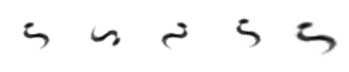

In [0]:
# Data augmentation example
i = 1063
fig, axs = plt.subplots(1,5, figsize=(6, 6))
axs[0].imshow(train_set_nonaug[i][0][0], cmap='gray')
axs[0].axis('off')
axs[1].imshow(train_set_aug_1[i][0][0], cmap='gray')
axs[1].axis('off')
axs[2].imshow(train_set_aug_2[i][0][0], cmap='gray')
axs[2].axis('off')
axs[3].imshow(train_set_aug_3[i][0][0], cmap='gray')
axs[3].axis('off')
axs[4].imshow(train_set_aug_4[i][0][0], cmap='gray')
axs[4].axis('off')
fig.show()

## Class distribution

In [0]:
train_loader = DataLoader(train_set_nonaug, batch_size=1024, shuffle=False, pin_memory=True, num_workers=2)
label_col = torch.tensor([], dtype=torch.long)
for batch_id, (inputs, labels) in enumerate(train_loader):
    label_col = torch.cat((label_col, labels), dim=0)
del inputs, labels

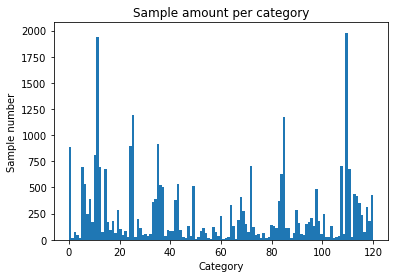

In [0]:
plt.title('Sample amount per category')
plt.xlabel('Category')
plt.ylabel('Sample number')
plt.hist(label_col, bins=121)
plt.show()

# Define model

In [0]:
class CNN(nn.Module):
    """
    ConvNet adapted from ResNet
    """
    def __init__(self, precnn, num_classes=len(classes)):
        super(CNN, self).__init__()
        self.precnn = nn.Sequential(*list(precnn.children())[1:-1])
        # Replace 1st conv to make it compatible with 1 channel input
        self.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False) 
        self.fc = nn.Linear(512, num_classes, bias=True) # Replace the last fc, 512 for ResNet18, 2048 for ResNet50
        
    def forward(self, x):
        x = self.conv0(x)
        x = self.precnn(x)
        x = torch.flatten(x, 1)
        output = self.fc(x)
        return output


# Training utils

In [0]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [0]:
def accuracy(pred, targets):
    num_correct = pred.argmax(dim=1).eq(targets).sum()
    acc = num_correct.float() / targets.size(0)
    return acc

In [0]:
def call_train(train_set, vali_set, cnn_save_path):
    epochs = 1000
    batch_size = 128
    lr = 1e-3
    patience = 5
    best_loss = np.inf
    best_epoch = 0
    cnn = CNN(models.resnet18(pretrained=False))
    cnn = cnn.cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(cnn.parameters(), lr=lr)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=5, verbose=True)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)
    vali_loader = DataLoader(vali_set, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=2)
    train_losses = []
    vali_losses = []

    for epoch in range(epochs):
        cnn.train()
        train_loss = AverageMeter()
        train_acc = AverageMeter()
        vali_loss = AverageMeter()
        vali_acc = AverageMeter()
        for batch_id, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = cnn(inputs)
            loss = criterion(outputs, labels)
            acc = accuracy(outputs, labels)
            train_acc.update(acc, inputs.size(0))
            loss.backward()
            optimizer.step()
            train_loss.update(loss.item(), inputs.size(0))
            if batch_id % 100 == 0:
                print("Batch: {}, loss {:.4f}.".format(batch_id, loss.item()))
        # Evaluation
        cnn.eval()
        with torch.no_grad():
            for batch_id, (inputs, labels) in enumerate(vali_loader):
                inputs, labels = inputs.cuda(), labels.cuda()
                outputs = cnn(inputs)
                loss = criterion(outputs, labels)
                acc = accuracy(outputs, labels)
                vali_loss.update(loss.item(), inputs.size(0))
                vali_acc.update(acc, inputs.size(0))
            # Adjust learning rate
            scheduler.step(train_loss.avg)
        print("Epoch: {}/{}, training loss: {:.4f}, train acc: {:.4f}, vali loss: {:.4f}, vali acc: \
{:.4f}.".format(epoch, epochs, train_loss.avg, train_acc.avg, vali_loss.avg, vali_acc.avg))
        train_losses.append(train_loss.avg)
        vali_losses.append(vali_loss.avg)
        # Save best
        if vali_loss.avg < best_loss:
            best_loss = vali_loss.avg
            best_epoch = epoch
            torch.save(cnn.state_dict(), cnn_save_path)
        # Early stopping
        if epoch - best_epoch >= patience:
            print("Early stopping")
            break

    print("Best epoch: {}, best loss: {:.4f}.".format(best_epoch, best_loss))
    gc.collect()
    torch.cuda.empty_cache()

# KFold train

In [0]:
# Collect all labels
train_len = len(train_set_nonaug)
all_id = np.array(range(train_len))
label_col = np.array(train_set_nonaug.targets)

In [0]:
skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)
i = 0
cnn_save_paths = [os.path.join(save_path, "res_ens_zhe_" + str(i)) for i in range(8)]

for train_id, vali_id in skf.split(all_id, label_col):
    print("---Split {}---".format(i))
    train_set = ConcatDataset([Subset(train_set_nonaug, train_id), Subset(train_set_aug_1, train_id),
                           Subset(train_set_aug_2, train_id), Subset(train_set_aug_3, train_id),
                           Subset(train_set_aug_4, train_id)])
    vali_set = Subset(train_set_nonaug, vali_id)
    call_train(train_set, vali_set, cnn_save_paths[i])
    i += 1

---Split 0---
Batch: 0, loss 4.7942.
Batch: 100, loss 2.1579.
Batch: 200, loss 2.0752.
Batch: 300, loss 2.0971.
Batch: 400, loss 1.8889.
Batch: 500, loss 1.7546.
Batch: 600, loss 1.3705.
Batch: 700, loss 1.6816.
Batch: 800, loss 1.4417.
Batch: 900, loss 1.3370.
Batch: 1000, loss 1.3004.
Epoch: 0/1000, training loss: 1.6929, train acc: 0.5141, vali loss: 1.4904, vali acc: 0.5607.
Batch: 0, loss 1.1664.
Batch: 100, loss 1.2634.
Batch: 200, loss 1.2249.
Batch: 300, loss 1.1963.
Batch: 400, loss 1.1652.
Batch: 500, loss 1.2719.
Batch: 600, loss 1.1345.
Batch: 700, loss 0.9210.
Batch: 800, loss 1.2823.
Batch: 900, loss 1.1115.
Batch: 1000, loss 1.3181.
Epoch: 1/1000, training loss: 1.1049, train acc: 0.6535, vali loss: 1.0665, vali acc: 0.6762.
Batch: 0, loss 1.0632.
Batch: 100, loss 0.9529.
Batch: 200, loss 0.8018.
Batch: 300, loss 0.8414.
Batch: 400, loss 0.8902.
Batch: 500, loss 0.6979.
Batch: 600, loss 1.0898.
Batch: 700, loss 1.0457.
Batch: 800, loss 0.7320.
Batch: 900, loss 0.6361.
Ba

In [0]:
gc.collect()
torch.cuda.empty_cache()

In [0]:
!nvidia-smi

Fri Apr  3 17:32:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    31W /  70W |   1263MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Train

In [0]:
# Collect all labels
train_len = len(train_set_nonaug)
all_id = np.array(range(train_len))
label_col = np.array(train_set_nonaug.targets)

In [0]:
# Stratifiedly split 1/8 as vali set
train_id, vali_id, train_label, vali_label = train_test_split(all_id, label_col, test_size=1/8, random_state=42, stratify=label_col)
vali_set = Subset(train_set_nonaug, vali_id)
train_set = ConcatDataset([Subset(train_set_nonaug, train_id), Subset(train_set_aug_1, train_id),
                           Subset(train_set_aug_2, train_id), Subset(train_set_aug_3, train_id),
                           Subset(train_set_aug_4, train_id)])
cnn_save_path = os.path.join(save_path, "res_one_zhe")
# Train
call_train(train_set, vali_set, cnn_save_path)

# KFold Prediction

In [0]:
test_loader = DataLoader(test_set, batch_size=1024, shuffle=False, pin_memory=True, num_workers=2)
cnn_save_paths = [os.path.join(save_path, "res_ens_zhe_" + str(i)) for i in range(8)]
cnn_pred = CNN(models.resnet18(pretrained=False))
cnn_pred = cnn_pred.cuda()
out_collection = []

for i in range(8):
    print("---Split {}---".format(i))
    cnn_pred.load_state_dict(torch.load(cnn_save_paths[i]))
    cnn_pred.eval()
    out_collection_i = np.zeros((0, len(classes)))
    with torch.no_grad():
        for batch_id, inputs in enumerate(test_loader):
            if batch_id % 50 == 0:
                print("Batch: {}.".format(batch_id))
            inputs = inputs.cuda()
            outputs = cnn_pred(inputs)
            outputs = F.softmax(outputs, dim=1)
            out_collection_i = np.concatenate((out_collection_i, outputs.cpu().numpy()), axis=0)
    out_collection.append(out_collection_i)

---Split 0---
Batch: 0.
Batch: 50.
Batch: 100.
---Split 1---
Batch: 0.
Batch: 50.
Batch: 100.
---Split 2---
Batch: 0.
Batch: 50.
Batch: 100.
---Split 3---
Batch: 0.
Batch: 50.
Batch: 100.
---Split 4---
Batch: 0.
Batch: 50.
Batch: 100.
---Split 5---
Batch: 0.
Batch: 50.
Batch: 100.
---Split 6---
Batch: 0.
Batch: 50.
Batch: 100.
---Split 7---
Batch: 0.
Batch: 50.
Batch: 100.


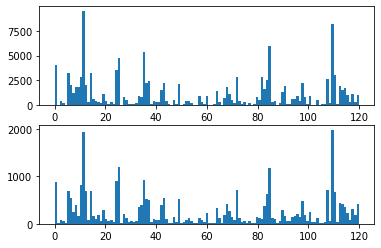

In [0]:
# Averaging prediction
out_collection = np.array(out_collection)
out_collection = out_collection.mean(axis=0)
fig, axs = plt.subplots(2)
axs[0].hist(out_collection.argmax(axis=1), bins=121)
axs[1].hist(label_col, bins=121)
fig.show()

# Prediction

In [0]:
test_loader = DataLoader(test_set, batch_size=1024, shuffle=False, pin_memory=True, num_workers=2)
cnn_pred =  CNN(models.resnet18(pretrained=False))
cnn_pred = cnn_pred.cuda()
cnn_pred.load_state_dict(torch.load(cnn_save_path))
cnn_pred.eval()
out_collection = np.zeros((0, len(classes)))

with torch.no_grad():
    for batch_id, inputs in enumerate(test_loader):
        if batch_id % 50 == 0:
            print("Batch: {}.".format(batch_id))
        inputs = inputs.cuda()
        outputs = cnn_pred(inputs)
        outputs = F.softmax(outputs, dim=1)
        out_collection = np.concatenate((out_collection, outputs.cpu().numpy()), axis=0)

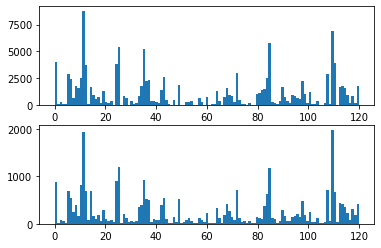

In [0]:
fig, axs = plt.subplots(2)
axs[0].hist(out_collection.argmax(axis=1), bins=121)
axs[1].hist(label_col, bins=121)

fig.show()

# Submission

In [0]:
submission_csv = pd.read_csv(os.path.join(csv_path, "sampleSubmission.csv"))

In [0]:
# Solve class misalignment
indices = []
for i in submission_csv.columns.to_list()[1:]:
    indices.append(classes.index(i))
classes_sorted = (np.array(classes))[indices]
out_collection = out_collection[:, indices]

In [0]:
submission_csv.loc[:, submission_csv.columns != 'image'] = out_collection
submission_csv

,image,acantharia_protist_big_center,acantharia_protist_halo,acantharia_protist,amphipods,appendicularian_fritillaridae,appendicularian_s_shape,appendicularian_slight_curve,appendicularian_straight,artifacts_edge,artifacts,chaetognath_non_sagitta,chaetognath_other,chaetognath_sagitta,chordate_type1,copepod_calanoid_eggs,copepod_calanoid_eucalanus,copepod_calanoid_flatheads,copepod_calanoid_frillyAntennae,copepod_calanoid_large_side_antennatucked,copepod_calanoid_large,copepod_calanoid_octomoms,copepod_calanoid_small_longantennae,copepod_calanoid,copepod_cyclopoid_copilia,copepod_cyclopoid_oithona_eggs,copepod_cyclopoid_oithona,copepod_other,crustacean_other,ctenophore_cestid,ctenophore_cydippid_no_tentacles,ctenophore_cydippid_tentacles,ctenophore_lobate,decapods,detritus_blob,detritus_filamentous,detritus_other,diatom_chain_string,diatom_chain_tube,echinoderm_larva_pluteus_brittlestar,...,polychaete,protist_dark_center,protist_fuzzy_olive,protist_noctiluca,protist_other,protist_star,pteropod_butterfly,pteropod_theco_dev_seq,pteropod_triangle,radiolarian_chain,radiolarian_colony,shrimp_caridean,shrimp_sergestidae,shrimp_zoea,shrimp-like_other,siphonophore_calycophoran_abylidae,siphonophore_calycophoran_rocketship_adult,siphonophore_calycophoran_rocketship_young,siphonophore_calycophoran_sphaeronectes_stem,siphonophore_calycophoran_sphaeronectes_young,siphonophore_calycophoran_sphaeronectes,siphonophore_other_parts,siphonophore_partial,siphonophore_physonect_young,siphonophore_physonect,stomatopod,tornaria_acorn_worm_larvae,trichodesmium_bowtie,trichodesmium_multiple,trichodesmium_puff,trichodesmium_tuft,trochophore_larvae,tunicate_doliolid_nurse,tunicate_doliolid,tunicate_partial,tunicate_salp_chains,tunicate_salp,unknown_blobs_and_smudges,unknown_sticks,unknown_unclassified
0,1.jpg,2.901500e-09,9.580143e-07,1.411901e-03,6.994398e-06,1.794654e-06,5.914893e-04,4.096868e-04,8.326411e-04,2.511762e-03,1.256936e-02,2.402563e-05,4.317521e-03,4.721258e-06,4.019559e-06,6.244769e-06,7.562546e-07,7.905654e-06,7.813334e-06,4.353316e-06,2.570538e-07,5.830547e-08,8.540587e-07,4.700779e-05,6.929275e-05,2.046752e-04,7.695224e-04,7.281881e-06,3.206357e-04,6.611596e-07,7.064684e-05,7.489184e-06,1.004838e-08,5.234111e-06,1.429736e-02,1.897734e-02,9.977256e-02,5.051068e-02,2.488683e-01,4.933850e-07,...,2.266984e-04,3.969057e-04,1.775378e-05,1.807486e-03,1.704964e-02,2.191805e-04,7.849830e-06,1.458904e-10,2.065245e-06,1.815274e-02,1.423981e-03,7.268586e-09,5.212136e-08,3.743716e-06,8.130995e-06,8.291844e-07,6.497686e-07,6.754752e-06,6.406052e-08,2.398454e-05,2.745449e-06,1.191664e-06,2.858809e-08,5.830425e-08,8.620532e-06,1.624100e-08,3.005204e-05,5.328665e-05,9.034289e-07,9.290713e-05,5.919811e-04,8.664326e-07,9.750986e-05,3.136205e-03,2.469939e-05,7.529788e-05,6.550036e-05,3.293713e-02,4.324879e-02,0.001341
1,10.jpg,2.947897e-10,7.255509e-07,1.540880e-05,8.632581e-05,8.762593e-09,3.088071e-08,6.287839e-08,2.482221e-07,1.992036e-09,6.036812e-10,1.183950e-07,2.166513e-05,2.613370e-07,5.335198e-13,5.376071e-05,3.531697e-05,5.896602e-03,1.980012e-04,1.095512e-05,3.047975e-06,3.508395e-05,9.665737e-07,6.718383e-03,6.595980e-10,2.080032e-01,7.663618e-01,3.046630e-05,7.849906e-05,9.453302e-13,5.463635e-10,9.463167e-09,4.843815e-11,6.046974e-08,5.218871e-05,2.244117e-04,8.703281e-03,2.318583e-08,2.566181e-06,1.406309e-07,...,1.628169e-07,1.751930e-04,3.949702e-07,1.695114e-06,2.103089e-05,1.421553e-07,9.266240e-07,1.201519e-10,3.766416e-07,1.205821e-07,3.630885e-07,7.380707e-09,2.202016e-09,2.546955e-06,1.077416e-05,3.080557e-07,1.648487e-10,1.609588e-07,6.963325e-10,2.580629e-08,8.848936e-10,1.493968e-09,1.484786e-10,2.035453e-11,5.132905e-11,3.750388e-12,7.792544e-10,2.151544e-05,3.982144e-08,1.365577e-04,4.495826e-04,1.804637e-09,9.132145e-09,2.905776e-08,5.079634e-08,4.168095e-11,2.278268e-07,2.192059e-03,6.686891e-06,0.000273
2,100.jpg,1.746551e-16,5.582368e-09,5.886141e-09,2.716617e-10,4.974569e-15,4.126678e-15,6.010184e-11,1.512276e-11,3.648756e

In [0]:
submission_csv.to_csv(os.path.join(csv_path, 'sub.csv'), index=False)

In [0]:
!kaggle competitions submit datasciencebowl -f sub.csv -m KFold-aug

100% 336M/336M [00:10<00:00, 34.8MB/s]
Successfully submitted to National Data Science Bowl

In [0]:
!kaggle competitions submissions datasciencebowls